Import library

In [ ]:
!pip install alibi-detect[tensorflow]

In [1]:
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import os
from turtle import end_fill
import cv2
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten
from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import random
import time
import datetime as dt
from itertools import chain

In [2]:
def trainimgload(directory,crop_size,size,testn):
    print('load 시작')
    dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
    images = os.listdir(directory)
    images.sort()
    for i, image_name in enumerate(images):
        if (image_name.split('.')[-1] == 'png'):
            image = cv2.imread(directory+ image_name)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image, 'RGB')
            if crop_size==0:
                pass
            else:
                image = image.crop(crop_size)
            image = image.resize((size, size))
            dataset.append(np.array(image))
    dataset = np.array(dataset)
    n=np.shape(dataset)[0]
    #trainn=round(n*trainratioP)
    trainn=n-testn
    if testn!=0:
        train = dataset[0:trainn]
        test = dataset[trainn:]
    else:
        train=dataset[0:n-1]
        testn=1
        test=dataset[n-1:]
    trainn=np.shape(train)[0]
    testn=np.shape(test)[0]
    train = train.astype('float32') / 255.
    test = test.astype('float32') / 255.
    print("train 갯수: ", trainn)
    print("val 갯수: ", testn)
    return train,test

이미지 로드

In [3]:
def imgload(directoryP,crop_size,SIZE,gray):
    image_directory = directoryP
    dirname=directoryP.split('/')[-2]
    #print(dirname, 'load시작')
    images = os.listdir(image_directory)
    images.sort()
    print(images)
    imgdataset=[]
    for i, image_name in enumerate(images):
        if (image_name.split('.')[-1] == 'png'):
            image = cv2.imread(image_directory + image_name)
            if gray==1:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
                image = Image.fromarray(image,mode="L")
            else:
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image, 'RGB')
            if crop_size==0:
                pass
            else:
                image = image.crop(crop_size)
            image = image.resize((SIZE, SIZE))
            if gray==1:
                image = np.reshape(image,(SIZE,SIZE,1))
            # image=np.array(image)
            # image[0:16,48:64,:]=0
            imgdataset.append(np.array(image))
    imgdataset = np.array(imgdataset)
    imgdatasetn=np.shape(imgdataset)
    imgdataset = imgdataset.astype('float32') / 255.
    # print(images[0])
    if imgdatasetn[0]!=1:
        print(dirname, " data number: ", imgdatasetn[0])
    return imgdataset, images

In [4]:
crop_size=0
dir="dataset/train/good/"
train,val=trainimgload(dir,crop_size,64,20)

load 시작
train 갯수:  248
val 갯수:  20


In [5]:
crop_size=0
dir="dataset/test/group/"
test,name=imgload(dir,crop_size,64,0)

['0good_0.png', '0good_1.png', '0good_2.png', '0good_3.png', '0good_4.png', '1bent_lead_0.png', '1bent_lead_1.png', '1bent_lead_2.png', '1bent_lead_3.png', '1bent_lead_4.png', '2cut_lead_0.png', '2cut_lead_1.png', '2cut_lead_2.png', '2cut_lead_3.png', '2cut_lead_4.png', '3damaged_case_0.png', '3damaged_case_1.png', '3damaged_case_2.png', '3damaged_case_3.png', '3damaged_case_4.png', '4misplaced_0.png', '4misplaced_1.png', '4misplaced_2.png', '4misplaced_3.png', '4misplaced_4.png']
group  data number:  25


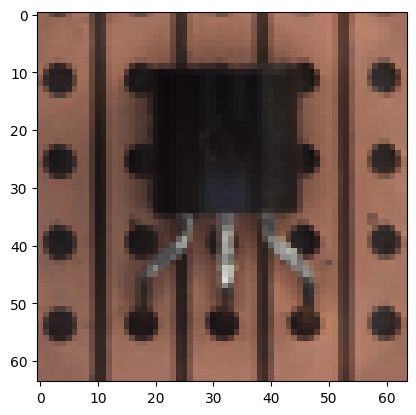

In [6]:
plt.imshow(test[3])

모델 변수 설정

In [11]:
size=64
#모델 변수
encoding_dim =1024
latent_dim = 1024
adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_thresehold=99.0
ep=5
batsize=10


모델 작성

In [8]:
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder.
#Define encoder
print(train[0].shape)
encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=train[0].shape),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
        Flatten(),
        Dense(encoding_dim,)
    ])
print(encoder_net.summary())

decoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(encoding_dim,)),
        Dense(np.prod(dense_dim)),
        Reshape(target_shape=dense_dim),
        Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
    ])
print(decoder_net.summary())

#latent_dim = latent_dim
# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=20)
print("Current threshold value is: ", od.threshold)


(64, 64, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34738880 (132.52 MB)
Trainable params: 34738880 (132.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


학습 시작

In [12]:
od.fit(train,
       optimizer = adam,
       epochs=ep,
       batch_size=batsize,
       verbose=True)

25/25 [=] - 28s 1s/step - loss_ma: -20355.2475


Threshold 설정

Current threshold value is:  0.002590830246917903


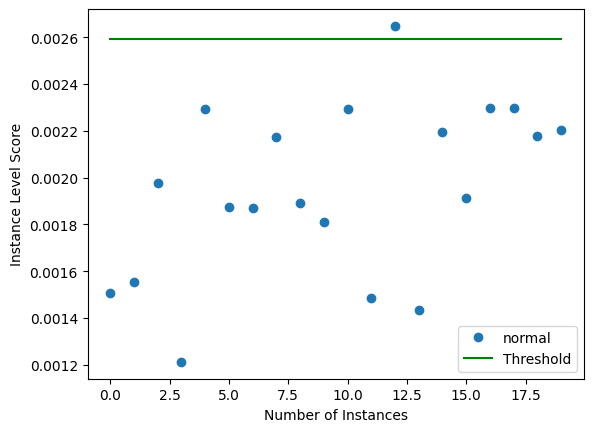

In [13]:
od.infer_threshold(val, outlier_type='instance', threshold_perc=train_thresehold)
print("Current threshold value is: ", od.threshold)

X = val
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
#Scatter plot of instance scores. using the built-in function for the scatterplot.
target = np.zeros(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

Model save

In [14]:
from alibi_detect.utils.saving import save_detector
filepath="model/model1"
save_detector(od, filepath)

Directory model\model1 does not exist and is now created.
Directory model\model1\model does not exist and is now created.


C:\Users\USER\miniforge3\envs\LGch\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model load

In [15]:
filepath="model/model1"
from alibi_detect.utils.saving import load_detector
od = load_detector(filepath)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.002590830246917903


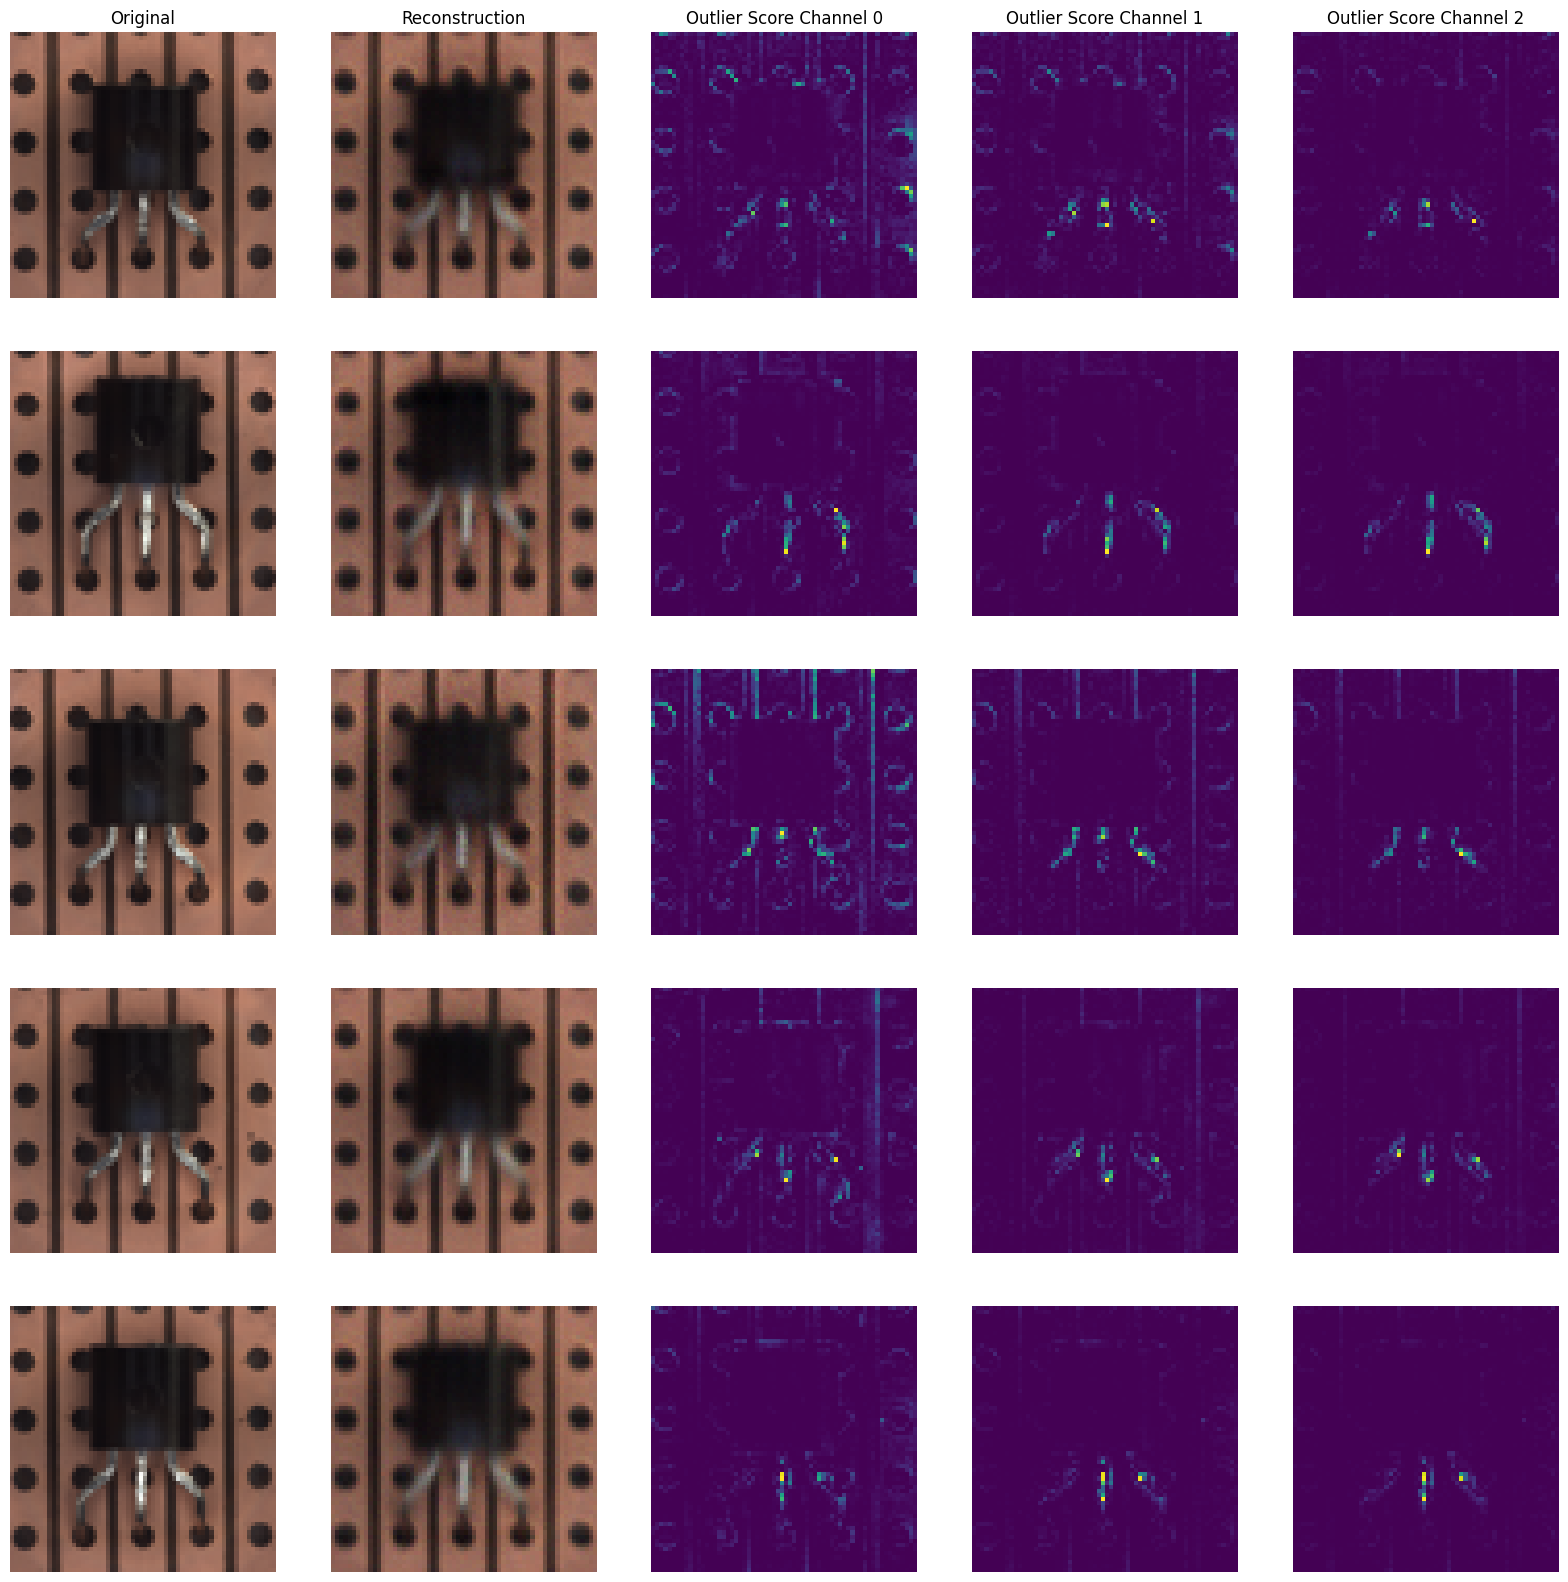

['0good_0.png', '0good_1.png', '0good_2.png', '0good_3.png', '0good_4.png']
[0.00142896 0.00343526 0.00323599 0.00165859 0.00179111]


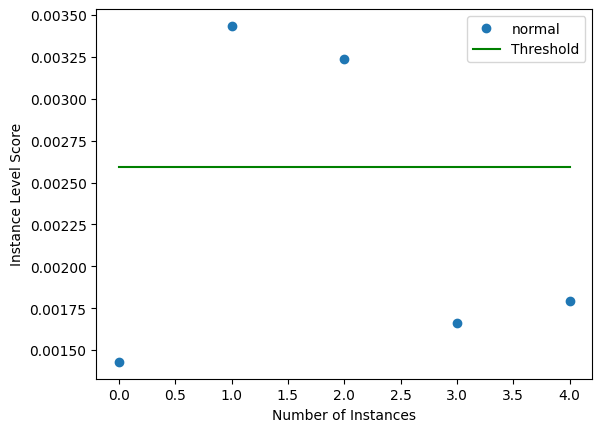

Current threshold value is:  0.002590830246917903


In [16]:
a=0
X = test[5*a:5*a+5]
od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False,
                           n_channels=3)  # only show outlier predictions
ascore = od_preds['data']['instance_score']
print(name[5*a:5*a+5])
print(ascore)
target = np.zeros(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)
print("Current threshold value is: ", od.threshold)
